## Отчет анализа стоимости ювелирных изделий у МЮЗ и ЭПЛ Даймонд

### 1. Парсинг 
 С сайта https://miuz.ru были спарсены изделия с фильтром - кольца - основной камнень бриллиант
https://miuz.ru/catalog/rings/filter/stones_main-is-brilliant/ 
Процесс парсинга, подробнее в файле ParsingMiuz.ipynb, процесс очистки и расчет прейскуратной стоимости
бриллиантов в файле for_parsing_func.ipynb

Всего колец с фильтром бриллиант на сайте более 5000 изделий, часть данных было отброшено по причинам:
- если изделие содержало другие камни или жемчуг кроме бриллианта
- изделие не могло правильно считаться парсером
- характеристики бриллиантов содержало ошибки
- были использованы фантазийные по цвету бриллианты (возможно синтетика)

В результате получен датасет с ювелирными изделиями со следующими данными (параметрами):
- Наименование(кольца только с бриллиантами  в количестве 1273 изделия), 
- Артикул,
- Ссылка на карточку с изделием (кликабельная ссылка)
- Стоимость изделия в рублях с учетом скидки (цены от 6труб до 1млн руб, на общую сумму 103 млн рублей, средняя стоимость 81т руб),
- масса изделия в граммах (от 0,86 до 22 грамма, общая масса 3172грамма средний вес 2,96 грамма),
- проба золота (585 проба - 1138 шт, 750 - 110шт, 375 - 26 шт),
- штук бриллиантов (всего 36724 штук, в среднем на изделие 29 бриллиантов)
- карат бриллиантов (всего 444 карат средняя масса камня 0,012 карат)
- прейскурантная стоимость бриллиантов в долларах (всего 206 тыс долларов, со средней прейскурантной стоимостью 464 доллара за карат)
Датасет приведен в файле _брилл_суммированы_mius161121_0-3178.xlsx

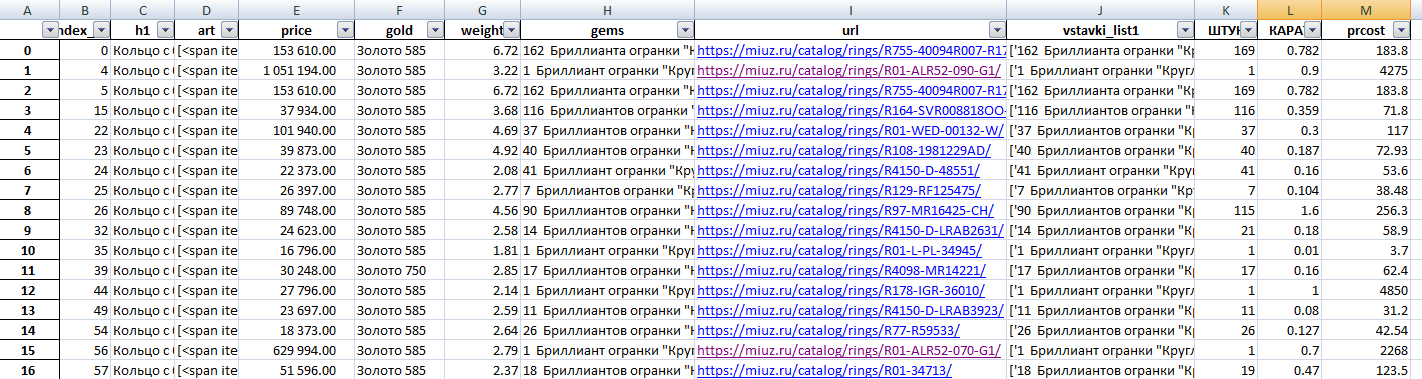

ЗАМЕЧАНИЯ: Данные были спарсены 16.11.2021, на сегодня 03.12.2021 были обнаружены изменения по цене! Дополнительные скидки и наценки !!! Необходимо в будущем повторить парсинг для изучения этого вопроса
- в изделии https://miuz.ru/catalog/rings/R01-ALR52-090-G1/ было 1 051 194 руб на сегодня 875 995 руб (при базовой цене 1 751 990 руб) 
- в изделии https://miuz.ru/catalog/rings/R4211-RG1059WDI1/  было 239 400 руб на сегодня 199 500 руб (при базовой цене 399 000 руб)
- в изделии https://miuz.ru/catalog/rings/R129-RF125059/  было 44 397 руб на сегодня 75 245 руб (при базовой цене  150 490 руб) 
_брилл_суммированы_mius161121_0-3178

### 2. Анализ датасета МЮЗ, визуализация, определение коэфициентов
#### 2.1 Считывание данных с файла, визуализация  
Построим облако точек в трехмерной плоскости
- х вес золота в граммах
- y стоимость прейскурантная бриллиантов
- z стоимость изделия в тысячах рублей

In [171]:
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt

In [172]:
#%matplotlib inline
%matplotlib notebook

In [173]:
filenamemiuz = 'jewels/miuz/_брилл_суммированы_mius161121_0-3178.xlsx'

In [174]:
raw = pd.read_excel(filenamemiuz,sheet_name=0)#[['price','weight','prcost']]

In [211]:
#ограничиваем датасет - изделия не дороже 500т руб и только проба 585
data = raw.loc[(raw.gold.str.contains('585') ),['price','weight','prcost']].loc[(raw.price<500000),:].loc[(raw.prcost<3000),:]

In [212]:
#сумма датасета
data.sum()

price     60854763.00
weight        3034.32
prcost      113494.67
dtype: float64

In [213]:
data.head()

,price,weight,prcost
0,153610,6.72,183.80
2,153610,6.72,183.80
3,37934,3.68,71.80
4,101940,4.69,117.00
5,39873,4.92,72.93


In [214]:
data.describe()

,price,weight,prcost
count,1124.000000,1124.000000,1124.000000
mean,54141.248221,2.699573,100.973906
std,58972.092479,1.132669,168.086013
min,8697.000000,0.960000,1.600000
25%,22373.000000,1.920000,20.535000
50%,34120.500000,2.415000,49.270000
75%,61270.500000,3.192500,103.500000
max,478194.000000,8.300000,1680.000000


<IPython.core.display.Javascript object>


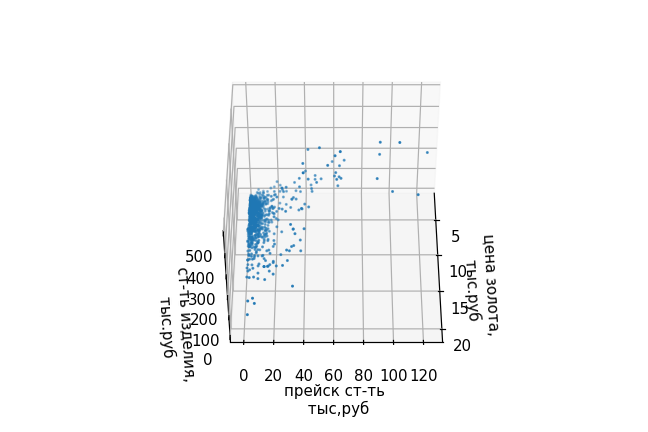

In [216]:
#визуализируем облако данных в трехмерном пространстве
ax = plt.axes(projection = "3d")
ax.scatter3D(data.weight,data.prcost,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('вес изделия, \n грамм')
ax.set_ylabel('прейск ст-ть \n брилл, долл')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(45,0)

#### 2.2 Подготовка данных для определения коэффициентов  

Для того чтобы полученные коэффициенты были имели интерпретируемый смысл, предлагается прейскурантную стоимость бриллиантов перевести в рубли, граммы золота перевести в биржевую стоимость золота, данного веса изделия в рублях. 

In [217]:
#Курс доллара и биржевая цена золота на 03-12-2021
dollar_rate = 73.66
gold_rate = 4191.05

In [218]:
data['prcost_rub'] = data.prcost*dollar_rate
data['gold_rub'] = data.weight*0.585*gold_rate

In [219]:
data

,price,weight,prcost,prcost_rub,gold_rub
0,153610,6.72,183.80,13538.7080,16475.855760
2,153610,6.72,183.80,13538.7080,16475.855760
3,37934,3.68,71.80,5288.7880,9022.492440
4,101940,4.69,117.00,8618.2200,11498.774333
5,39873,4.92,72.93,5372.0238,12062.680110
...,...,...,...,...,...
1269,13497,1.09,22.40,1649.9840,2672.423033
1270,36196,2.86,36.66,2700.3756,7012.045755
1271,23397,1.77,18.40,1355.3440,4339.622723
1272,16495,1.39,18.00,1325.8800,3407.952307


<IPython.core.display.Javascript object>


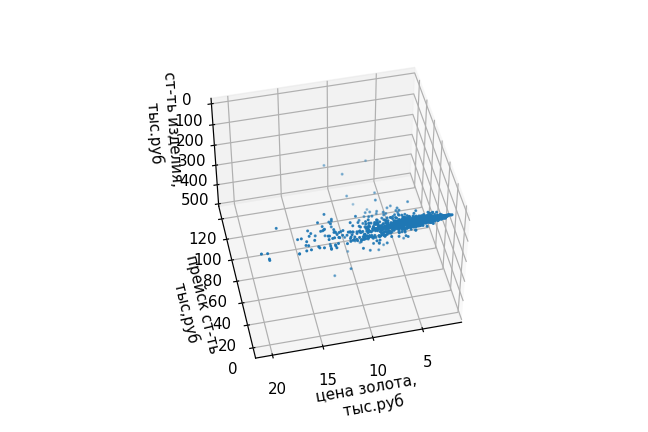

In [222]:
ax = plt.axes(projection = "3d")
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(45,0)

In [225]:
X_train = data.iloc[:,:].loc[:,['gold_rub','prcost_rub']].to_numpy()
Y_train = data.iloc[:,:].loc[:,'price'].to_numpy()

In [226]:
from sklearn import linear_model

In [227]:
miuz = linear_model.LinearRegression()

In [228]:
miuz.fit(X_train,Y_train)

LinearRegression()

In [229]:
miuz.coef_

array([3.30068907, 4.04557582])

In [233]:
miuz.predict(X_train)

array([111358.53726582, 111358.53726582,  53381.62559249, ...,
        22011.8827889 ,  18817.52959189, 119169.9827475 ])

In [ ]:
x_val = np.linspace()

In [232]:
10*3.30+10*4.04


73.4

In [105]:
from numpy.testing._private.decorators import slow

In [107]:
from sklearn import linear_model

In [103]:
# импорт необходимых модулей
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


In [108]:
from sklearn import datasets

In [131]:
#filenamekdm =  'jewels/kdm/_АНАЛИЗ_брилл_суммированы__объединенная_по_jewelsartemeva16112021.xlsx'
filenamekd = 'jewels/kdm/_брилл_суммированы__объединенная_по_jewelssprint2data.xlsx'
rawkdm = pd.read_excel(filenamekd)#[['price','weight','prcost']]

In [132]:
rawkdm

,Unnamed: 0,index_row,пп,id7c,Изделие,Артикул,Unnamed: 5,НоменГр,Проба,Цвет металла,...,Unnamed: 29,Unnamed: 30,Unnamed: 31,1.92,checklog,vs_dict,gem,ШТУК,КАРАТ,prcost
0,0,0,1.0,93280,Кольцо,06/511042,12387,Т ДМ Юи с ДК,585,красное,...,NaN,NaN,NaN,NaN,NaN,"[('1', 'Кр57', '0,180', '4/5', 'А')]",[],1.0,0.180,116.10
1,1,1,2.0,93282,Кольцо,511100,7350,Т ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('1', 'Кр57', '0,080', '5/2', 'А'), ('2', 'Кр...",[],3.0,0.116,52.16
2,2,2,3.0,93286,Кольцо,511100,10035,Т ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('1', 'Кр57', '0,080', '5/5', 'А'), ('2', 'Кр...",[],3.0,0.110,41.10
3,3,3,4.0,93288,Кольцо,511100,10048,Т ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('1', 'Кр57', '0,080', '5/5', 'А'), ('2', 'Кр...",[],3.0,0.120,45.20
4,4,4,5.0,93289,Кольцо,511100,10046,Т ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('1', 'Кр57', '0,080', '6/2', 'А'), ('2', 'Кр...",[],3.0,0.120,46.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31689,31689,31689,18.0,МС00127930,Серьги,2с0150,84493.21,П ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('5', 'Кр57', '0,630', '4/3', 'А'), ('2', 'Кр...",[],10.0,1.227,696.09
31690,31690,31690,19.0,МС00127934,Серьги,2с0150,84497.21,П ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('2', 'Кр57', '0,260', '5/3', 'А'), ('2', 'Кр...",[],10.0,1.220,561.65
31691,31691,31691,20.0,МС00127937,Серьги,2с0150,84504.21,П ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('1', 'Кр57', '0,160', '2/5', 'А'), ('1', 'Кр...",[],10.0,1.587,1052.41
31692,31692,31692,21.0,МС00127939,Серьги,2с0150,84506.21,П ДМ Юи с ДК,585,комбинированное,...,NaN,NaN,NaN,NaN,NaN,"[('1', 'Кр57', '0,158', '3/5', 'А'), ('4', 'Кр...",[],10.0,1.558,882.31


In [106]:
import pandas as pd

In [147]:
kdm.fit(Xkdm_train,Ykdm_train)

LinearRegression()

In [133]:
rawkdm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31694 entries, 0 to 31693
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         31694 non-null  int64  
 1   index_row          31694 non-null  int64  
 2   пп                 31647 non-null  float64
 3   id7c               31694 non-null  object 
 4   Изделие            31694 non-null  object 
 5   Артикул            31693 non-null  object 
 6   Unnamed: 5         7052 non-null   object 
 7   НоменГр            31694 non-null  object 
 8   Проба              31694 non-null  object 
 9   Цвет металла       31688 non-null  object 
 10  Кол                31694 non-null  int64  
 11  Вес                31694 non-null  float64
 12  Закуп              31694 non-null  float64
 13  Розн               31694 non-null  float64
 14  Вставки            27625 non-null  object 
 15  Размер             30959 non-null  object 
 16  РазмернаяГруппаЦК  191

In [134]:
datakdm = rawkdm[['id7c','Изделие','Проба','gem','Вес', 'Закуп','prcost',]].loc[(~rawkdm.prcost.isna())]#&(rawkdm.Розн<100000)&(rawkdm.prcost<400)]

In [135]:
len(datakdm)

6636

In [153]:
datakdm.Проба.unique()

array(['585', '750', '750-950', '750-585', '583'], dtype=object)

In [156]:
datakdm.loc[datakdm.Проба ==  '583']

,id7c,Изделие,Проба,gem,Вес,Закуп,prcost
21350,169438,Подвеска,583,[],2.76,1665.62,0.95


In [145]:
Xkdm_train = datakdm.iloc[:,:].loc[:,['Вес','prcost']].to_numpy()
Ykdm_train = datakdm.iloc[:,:].loc[:,'Закуп'].to_numpy()

In [146]:
Ykdm_train.shape

(6636,)

In [141]:
kdm = linear_model.LinearRegression()

In [142]:
Xkdm_train,Ykdm_train

(array([[2.34000e+00, 1.16100e+02],
        [3.47000e+00, 5.21600e+01],
        [2.89000e+00, 4.11000e+01],
        [3.26000e+00, 4.52000e+01],
        [3.36000e+00, 4.68000e+01],
        [3.02000e+00, 5.28500e+01],
        [3.30000e+00, 5.64500e+01],
        [3.47000e+00, 4.62800e+01],
        [3.47000e+00, 5.64500e+01],
        [3.38000e+00, 4.29600e+01],
        [3.71000e+00, 4.63200e+01],
        [3.71000e+00, 4.25800e+01],
        [3.25000e+00, 2.44500e+01],
        [2.92000e+00, 3.56500e+01],
        [3.43000e+00, 5.64500e+01],
        [3.40000e+00, 5.28500e+01],
        [6.63000e+00, 1.03500e+02],
        [6.59000e+00, 1.03500e+02],
        [6.48000e+00, 1.03500e+02],
        [6.71000e+00, 9.93000e+01],
        [6.81000e+00, 9.93000e+01],
        [6.81000e+00, 1.24600e+02],
        [6.83000e+00, 9.75000e+01],
        [6.84000e+00, 1.00200e+02],
        [6.86000e+00, 9.38500e+01],
        [6.78000e+00, 1.09250e+02],
        [6.71000e+00, 1.03800e+02],
        [6.87000e+00, 1.1620

In [148]:
kdm.coef_

array([2172.66686256,  115.7555359 ])

In [157]:
def plot_figs_kdm(fig_num, elev, azim, X_train, clf):
    fig = plt.figure(fig_num, figsize=(10, 10))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim)

    ax.scatter(Xkdm_train[:, 0], Xkdm_train[:, 1], Ykdm_train, c="k", marker="+")
    #ax.plot_surface(
    #    np.array([[-0.1, -0.1], [0.15, 0.15]]),
     #   np.array([[-0.1, 0.15], [-0.1, 0.15]]),
      #  clf.predict(
       #     np.array([[-0.1, -0.1, 0.15, 0.15], [-0.1, 0.15, -0.1, 0.15]]).T
       # ).reshape((2, 2)),
       # alpha=0.5,
    #)
    ax.set_xlabel("X_1")
    ax.set_ylabel("X_2")
    ax.set_zlabel("Y")
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])


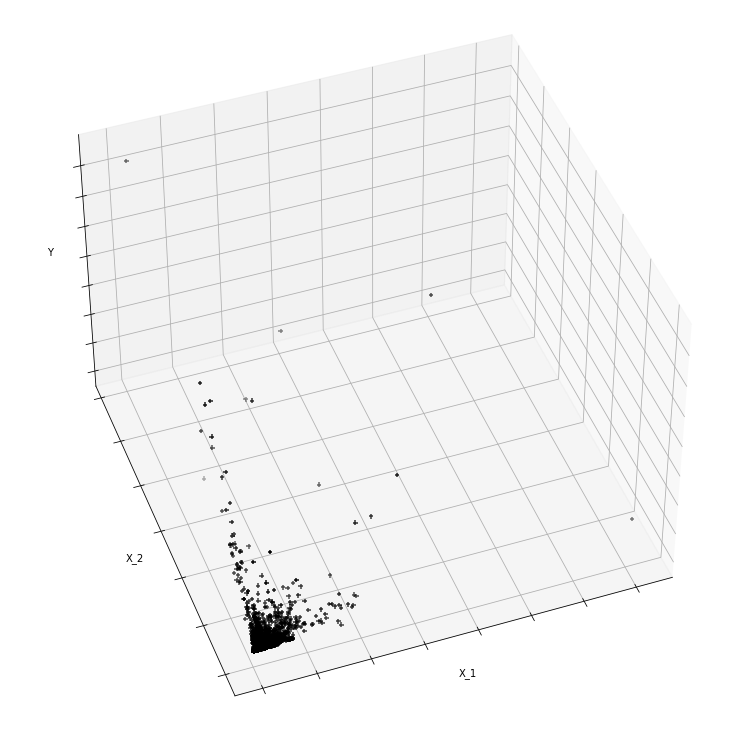

In [158]:
elev = 43.5
azim = -110
plot_figs_kdm(1, elev, azim, Xkdm_train, kdm)


In [162]:
fig2 = plt.figure(1, figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<IPython.core.display.Javascript object>


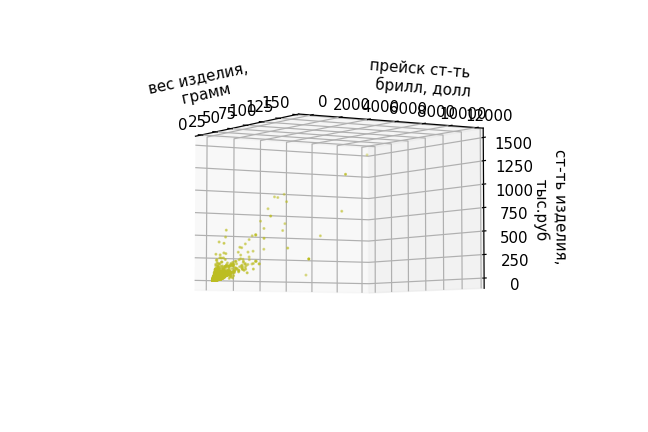

In [168]:
ax = plt.axes(projection='3d')
#ax.scatter3D(data.weight,data.prcost,data.price/1000,s=1,
#             c=data.goldcarat.apply(lambda x: '#2ca02c' if x == 14 else  '#ff7f0e'))
ax.scatter3D(datakdm.Вес,datakdm.prcost,datakdm.Закуп/1000,s=1,
             c=datakdm.Проба.apply(lambda x: '#1f77b4' if x == 585 else '#bcbd22'))
ax.set_xlabel('вес изделия, \n грамм')
ax.set_ylabel('прейск ст-ть \n брилл, долл')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(0,0)

In [169]:
plt.axes?

In [11]:
X_train = X[:-20, indices]
X_test = X[-20:, indices]
y_train = y[:-20]
y_test = y[-20:]

ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)


NameError: name 'X' is not defined

In [7]:
X, y = datasets.load_diabetes(return_X_y=True)
indices = (0, 1)

In [39]:
type(y)
#X[:-20, indices]

numpy.ndarray

In [42]:
y.shape

(442,)

In [32]:
Xkdm_train

array([[  2.7 , 149.5 ,    nan],
       [  2.64, 149.5 ,    nan],
       [  2.68, 123.75,    nan],
       ...,
       [  2.99,  18.48,    nan],
       [  5.68,  54.98,    nan],
       [  5.06,  14.59,    nan]])

In [68]:
kdm.coef_

array([8157.20086656,  351.2588523 ])

In [14]:
kdm_coef = [8157.20086656,  351.2588523 ]

In [52]:
for i in range(100):
    predict, fact = (Xkdm_train[i,0]*kdm_coef[0]+Xkdm_train[i,1]*kdm_coef[1], Ykdm_train[i])
    print (' {}  {:6.2f}   {:6.6f}   {:4.1%}'.format(i, predict, fact, (fact - predict)/fact))

 0  74537.64   98588.304000   24.4%
 1  74048.21   97826.520000   24.3%
 2  65329.58   89593.296000   27.1%
 3  47306.25   63730.416000   25.8%
 4  60186.13   80278.368000   25.0%
 5  61830.39   82093.128000   24.7%
 6  58799.41   78119.880000   24.7%
 7  59778.27   79643.520000   24.9%
 8  63135.54   84124.632000   24.9%
 9  54004.72   71965.368000   25.0%
 10  52282.81   70110.720000   25.4%
 11  50940.61   68486.520000   25.6%
 12  47654.76   64016.760000   25.6%
 13  45863.34   61712.064000   25.7%
 14  42743.80   57985.368000   26.3%
 15  41834.79   56441.640000   25.9%
 16  57422.51   76744.896000   25.2%
 17  55709.49   74078.568000   24.8%
 18  56851.50   75856.152000   25.1%
 19  56606.79   75475.248000   25.0%
 20  56851.50   75856.152000   25.1%
 21  49127.72   66015.480000   25.6%
 22  49535.58   66650.280000   25.7%
 23  46735.25   62841.696000   25.6%
 24  47469.39   63984.408000   25.8%
 25  44428.01   61612.320000   27.9%
 26  43938.58   60850.488000   27.8%
 27  50729.

In [67]:
Ykdm_train[85], Xkdm_train[85]

(48748.104, array([  2.7 , 260.06]))

In [66]:
rawkdm.loc[abs(48748.104000- rawkdm.loc[:, 'Розн']) <=0.000001,['Изделие', 'Артикул',
       'Проба', 'Вес', 'Закуп','Розн', 'Вставки', 'filname', 'vs_dict', 'gem', 'ШТУК', 'КАРАТ', 'prcost',]]

,Изделие,Артикул,Проба,Вес,Закуп,Розн,Вставки,filname,vs_dict,gem,ШТУК,КАРАТ,prcost
2139,Подвеска,10523278,585,2.7,20311.71,48748.104,"29КР57-0,556-2/4А 1КР57-0,020-2/8А",8ка144догДЯИспр.xls,"[('29', 'КР57', '0,556', '2/4', 'А'), ('1', 'К...",[],30.0,0.576,260.06


In [77]:
z = lambda x,y: (-kdm.intercept_[0]-kdm.coef_[0][0]*x-kdm.coef_[0][1]*y)# / svc.coef_[0][2]

tmpX = np.linspace(0,10,51)
tmpY = np.linspace(0,250,51)
tmpZ = z(tmpX,tmpY)
x,y = np.meshgrid(tmpX,tmpY)

IndexError: invalid index to scalar variable.

In [17]:
len(X_train)

422

In [18]:
len(y_train)

422

In [47]:
def plot_figs(fig_num, elev, azim, X_train, clf):
    fig = plt.figure(fig_num, figsize=(10, 10))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim)

    #ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c="k", marker="+")
    ax.plot_surface(
        np.array([[-0.1, -0.1], [0.15, 0.15]]),
        np.array([[-0.1, 0.15], [-0.1, 0.15]]),
        clf.predict(
            np.array([[-0.1, -0.1, 0.15, 0.15], [-0.1, 0.15, -0.1, 0.15]]).T
        ).reshape((2, 2)),
        alpha=0.5,
    )
    ax.set_xlabel("X_1")
    ax.set_ylabel("X_2")
    ax.set_zlabel("Y")
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])


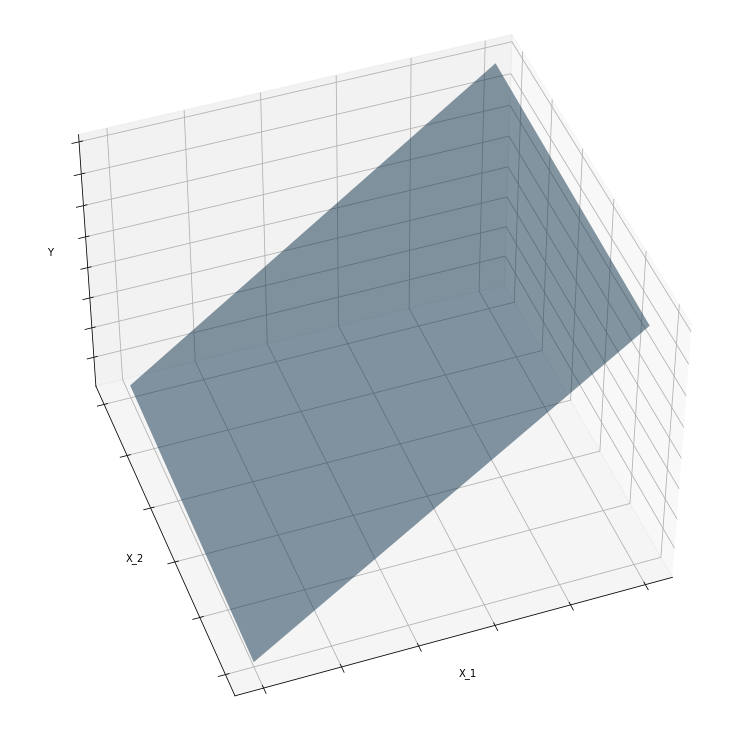

In [48]:
elev = 43.5
azim = -110
plot_figs(1, elev, azim, X_train, ols)
